In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EURO

In [ ]:
!unzip /content/drive/MyDrive/bass/week4/Train_Test_Splits.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import os

# Define data transformations for training and testing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = '/content/Train_Test_Splits'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset_sizes

{'train': 21600, 'test': 5400}

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 324MB/s]


Epoch 0/14
train_loss: 0.1973, train_acc: 0.9380
valid_loss: 0.1471, valid_acc: 0.9542
Epoch 1/14
train_loss: 0.1823, train_acc: 0.9427
valid_loss: 0.1265, valid_acc: 0.9630
Epoch 2/14
train_loss: 0.1719, train_acc: 0.9468
valid_loss: 0.1307, valid_acc: 0.9609
Epoch 3/14
train_loss: 0.1628, train_acc: 0.9460
valid_loss: 0.1330, valid_acc: 0.9597
Epoch 4/14
train_loss: 0.1559, train_acc: 0.9519
valid_loss: 0.1245, valid_acc: 0.9595
Epoch 5/14
train_loss: 0.1436, train_acc: 0.9543
valid_loss: 0.1312, valid_acc: 0.9611
Epoch 6/14
train_loss: 0.1425, train_acc: 0.9553
valid_loss: 0.1105, valid_acc: 0.9637
Epoch 7/14
train_loss: 0.1362, train_acc: 0.9569
valid_loss: 0.1366, valid_acc: 0.9581
Epoch 8/14
train_loss: 0.1183, train_acc: 0.9628
valid_loss: 0.1245, valid_acc: 0.9588
Epoch 9/14
train_loss: 0.1217, train_acc: 0.9622
valid_loss: 0.1217, valid_acc: 0.9630
Epoch 10/14
train_loss: 0.1236, train_acc: 0.9608
valid_loss: 0.1057, valid_acc: 0.9655
Epoch 11/14
train_loss: 0.1098, train_acc:

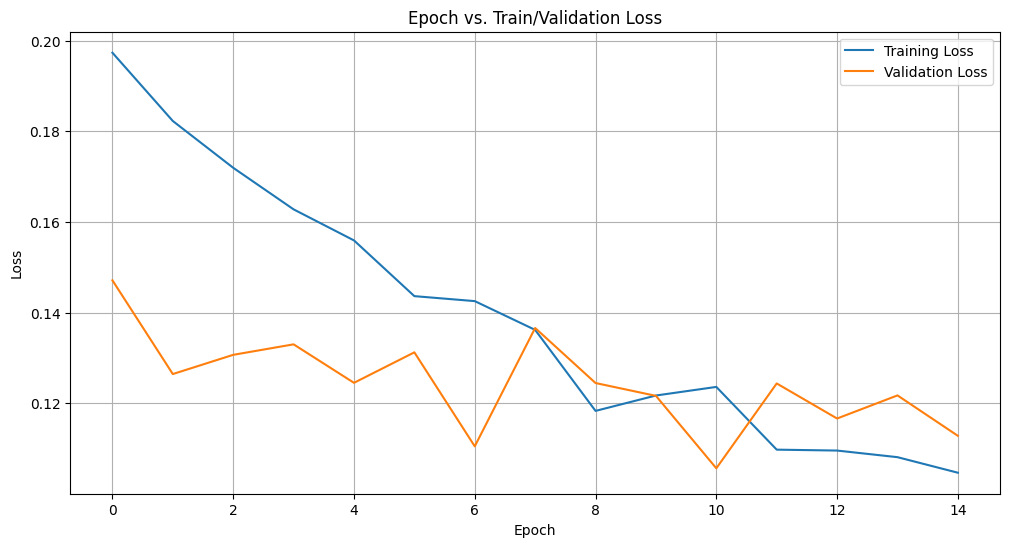

In [ ]:
import numpy as np
from torch.utils.data import random_split
import matplotlib.pyplot as plt

# Split the dataset
train_dataset = image_datasets['train']
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

dataloaders['train'] = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(valid_subset, batch_size=32, shuffle=False, num_workers=4)
dataset_sizes['train'] = len(train_subset)
dataset_sizes['valid'] = len(valid_subset)

# record the loss
train_losses = []
valid_losses = []

# Training and validation loop
# for eacch epoch, there will be a training and validation
num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    metrics = {
        'train': {'loss': 0.0, 'correct': 0},
        'valid': {'loss': 0.0, 'correct': 0}
    }

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()  # training mode
        else:
            model.eval()   # evaluate mode

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Update metrics
            metrics[phase]['loss'] += loss.item() * inputs.size(0)
            metrics[phase]['correct'] += torch.sum(preds == labels.data)

        # Calculate epoch metrics
        epoch_loss = metrics[phase]['loss'] / dataset_sizes[phase]
        epoch_acc = metrics[phase]['correct'].double() / dataset_sizes[phase]
        print(f"{phase}_loss: {epoch_loss:.4f}, {phase}_acc: {epoch_acc:.4f}")

    train_losses.append(metrics['train']['loss'] / dataset_sizes['train'])
    valid_losses.append(metrics['valid']['loss'] / dataset_sizes['valid'])


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs. Train/Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(model, '/content/drive/MyDrive/bass/model.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test data: 98.30%


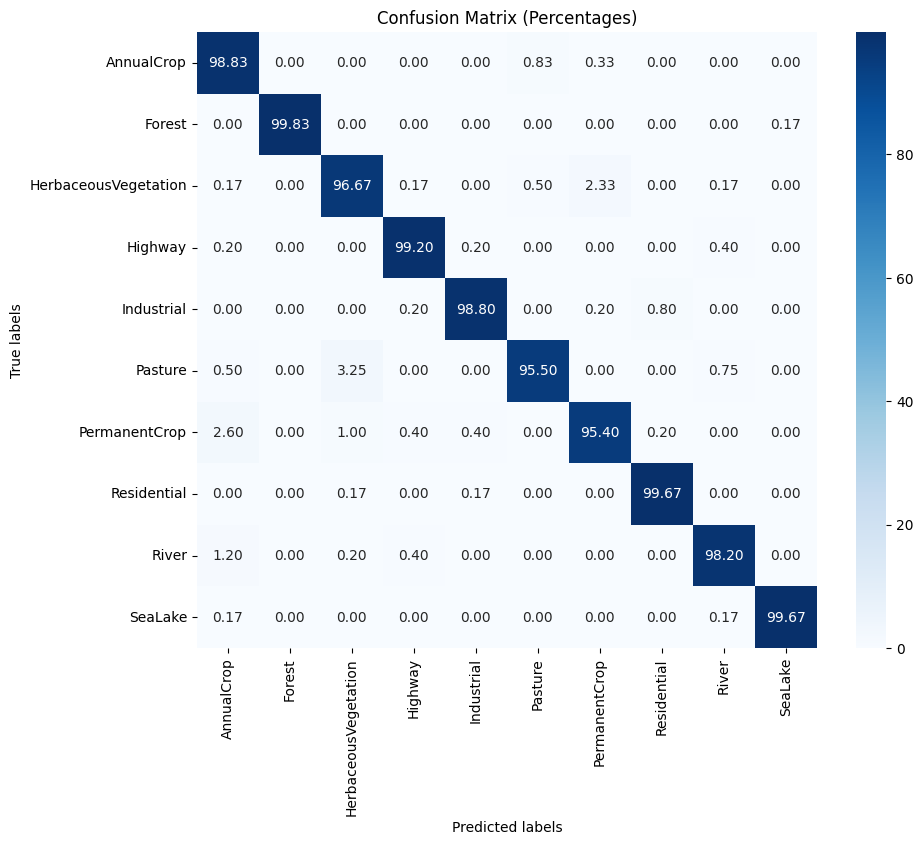

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# record the label
all_labels = []
all_predictions = []

# get class names, as the predictions are directly numbers
class_names = image_datasets['test'].classes

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized * 100, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Percentages)')
plt.show()

In [ ]:
# def denormalize(img_array, mean, std):
#     for i in range(3):  # Assuming 3 channels for RGB
#         img_array[i, :, :] = img_array[i, :, :] * std[i] + mean[i]
#     return img_array

# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-34-f4086dad5f5e>:28: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  all_inputs = np.array(all_inputs)

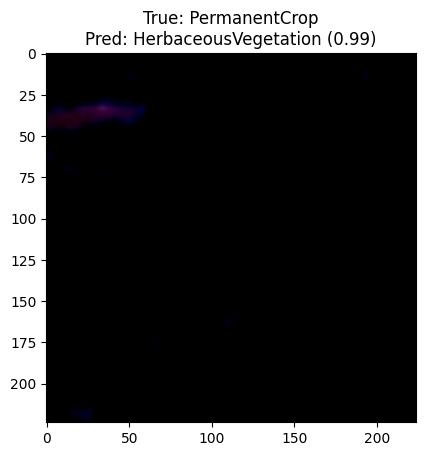

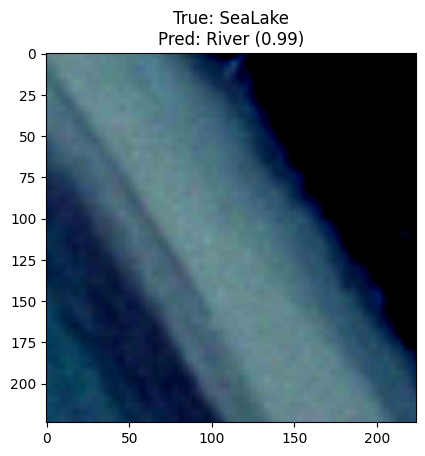

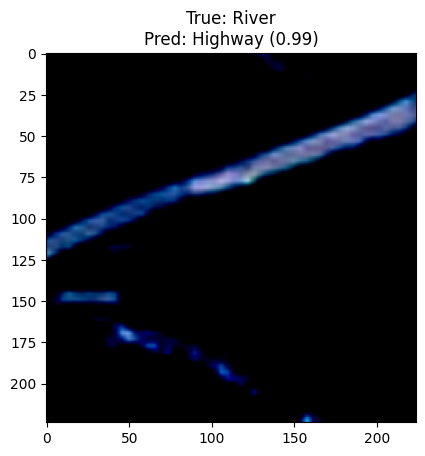

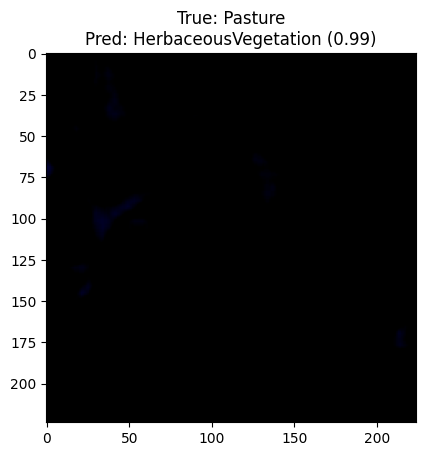

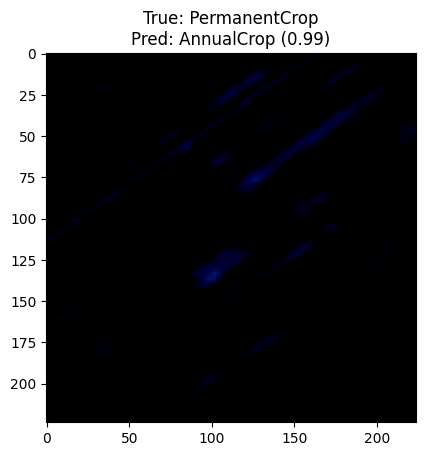

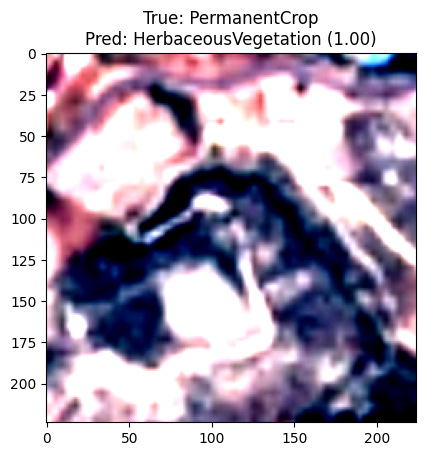

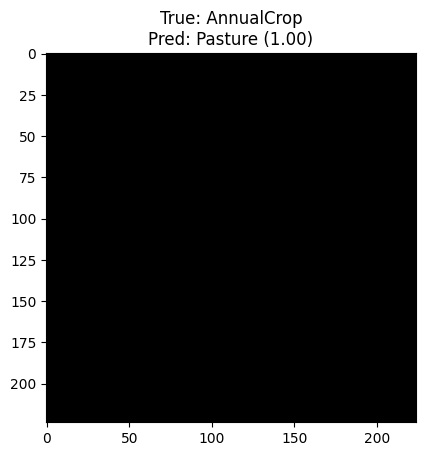

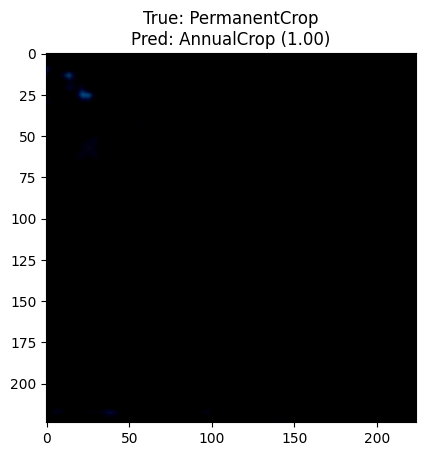

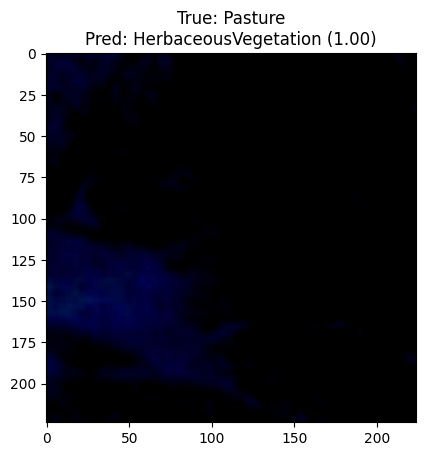

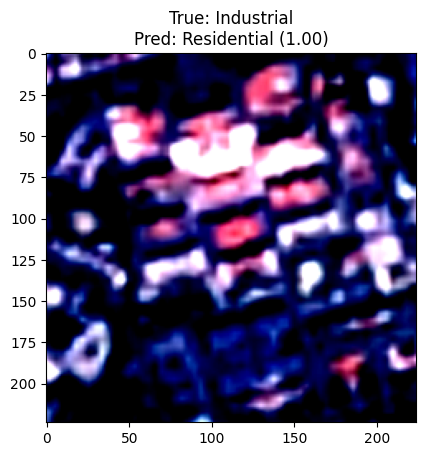

Highest confidence score for an error: 1.00
Class incorrectly predicted with highest confidence: Residential


In [ ]:
import numpy as np

# Record the probs
all_probs = []
all_labels = []
all_predictions = []
all_inputs = []

# Calculate softmax probabilities and store them
softmax = nn.Softmax(dim=1)
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # print(outputs)
        probs = softmax(outputs)
        _, predicted = outputs.max(1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_inputs.extend(inputs.cpu())

# Convert lists to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_inputs = np.array(all_inputs)

# Identify incorrect predictions
incorrect_indices = np.where(all_predictions != all_labels)[0]
correct_indices = np.where(all_predictions == all_labels)[0]

# Sort incorrect predictions by confidence
sorted_indices = np.argsort(all_probs[incorrect_indices, all_predictions[incorrect_indices]])

# Top 10 high
high_confidence_errors = incorrect_indices[sorted_indices[-10:]]
for idx in high_confidence_errors:
    true_label = class_names[all_labels[idx]]
    predicted_label = class_names[all_predictions[idx]]
    confidence = all_probs[idx, all_predictions[idx]]

    plt.imshow(np.transpose(all_inputs[idx], (1, 2, 0)))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f})")
    plt.show()

# Find the highest confidence score
max_confidence_error = np.max(all_probs[incorrect_indices, all_predictions[incorrect_indices]])
print(f"Highest confidence score for an error: {max_confidence_error:.2f}")

# Identify the class that was incorrectly predicted with the highest confidence
class_with_max_confidence_error = class_names[all_predictions[incorrect_indices[np.argmax(all_probs[incorrect_indices, all_predictions[incorrect_indices]])]]]
print(f"Class incorrectly predicted with highest confidence: {class_with_max_confidence_error}")


Low Confidence Errors:


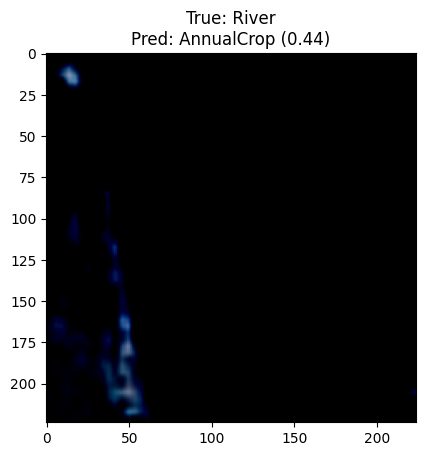

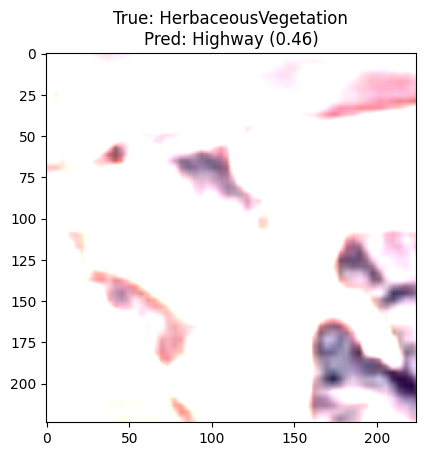

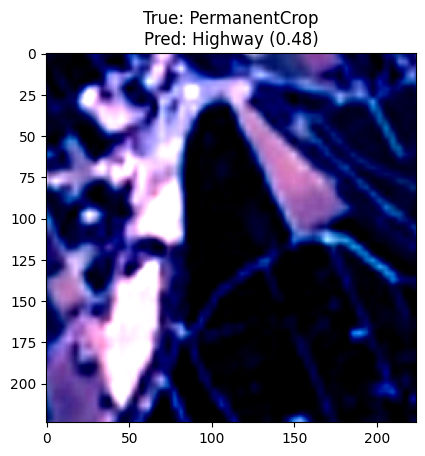

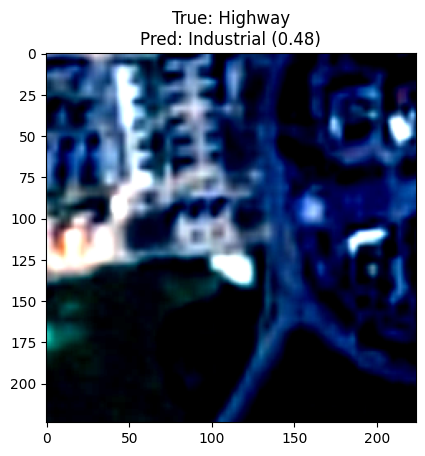

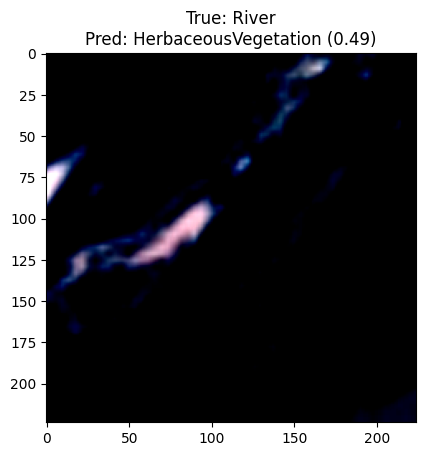

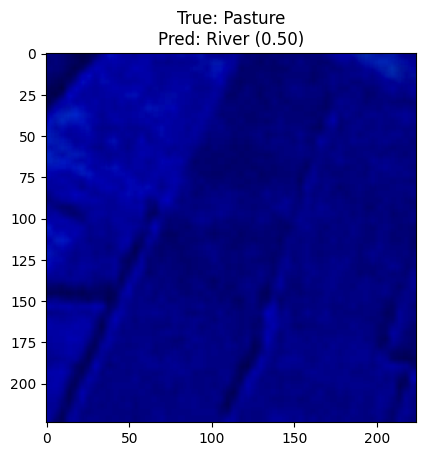

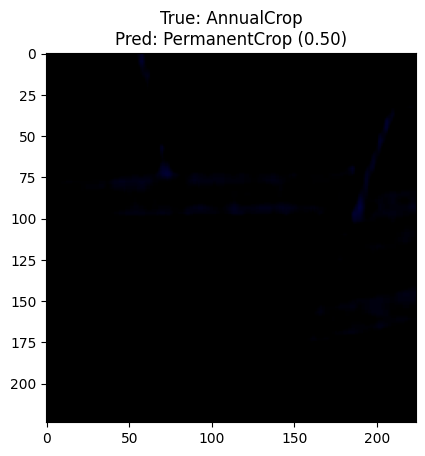

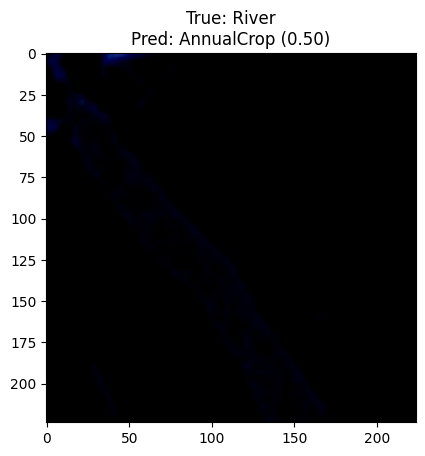

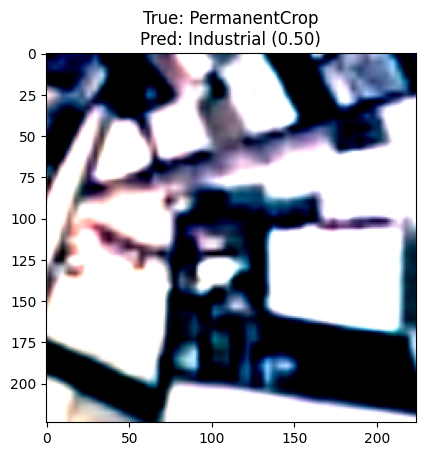

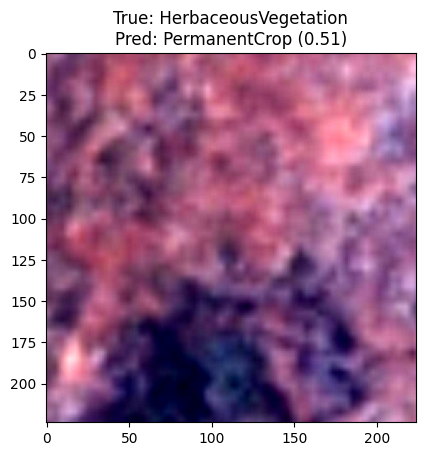

In [ ]:

# Top 10 low
low_confidence_errors = incorrect_indices[sorted_indices[:10]]
print("Low Confidence Errors:")
for idx in low_confidence_errors:

    true_label = class_names[all_labels[idx]]
    predicted_label = class_names[all_predictions[idx]]
    confidence = all_probs[idx, all_predictions[idx]]

    plt.imshow(np.transpose(all_inputs[idx], (1, 2, 0)))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f})")
    plt.show()


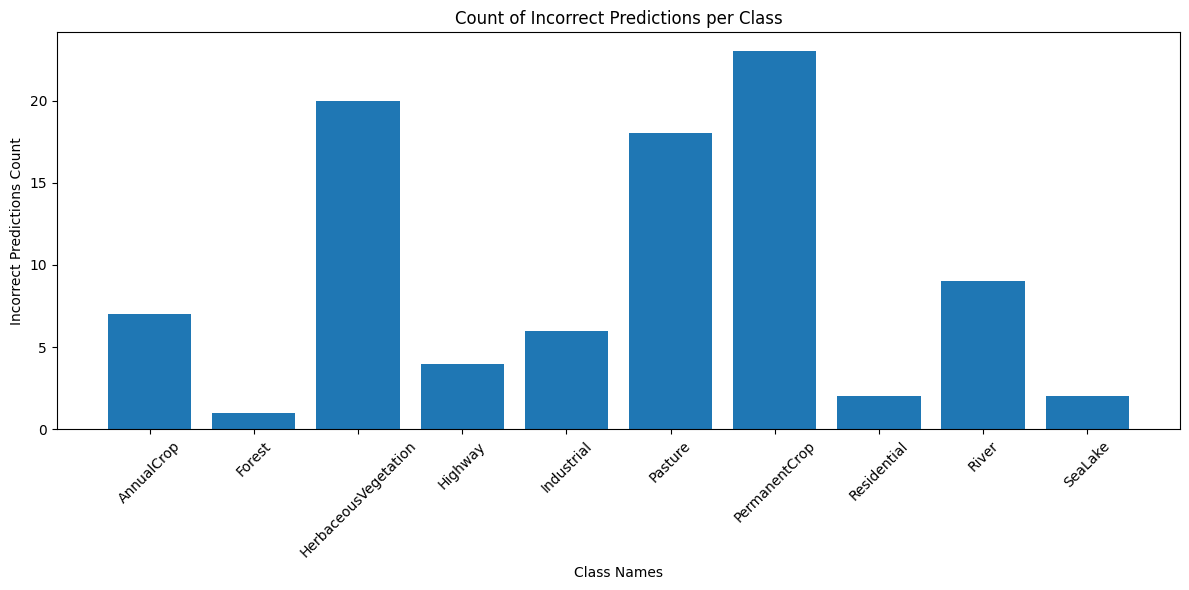

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predictions)
incorrect_counts = cm.sum(axis=1) - np.diag(cm)

# Plot the counts of incorrect predictions
plt.figure(figsize=(12, 6))
plt.bar(class_names, incorrect_counts)
plt.xlabel('Class Names')
plt.ylabel('Incorrect Predictions Count')
plt.title('Count of Incorrect Predictions per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
